<h1>Tracking the spread of 2019 Coronavirus in France</h1>

## Introduction

This are statistics for the spread in France of 2019-nCoV, a highly contagious coronavirus that originated from Wuhan (Hubei province), Mainland China. 
France is a neighbouring country of the second mainly infected at the time this database has been created, Italy




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

raw_data = pd.read_csv( "../input/coronavirusdataset-france/chiffres-cles.csv", parse_dates=['date']) # raw dataframe
df_china = pd.read_csv( "../input/coronavirusdataset-france/china.csv", parse_dates=['date'])
df_italy = pd.read_csv( "../input/coronavirusdataset-france/contagioitalia.csv", parse_dates=['date'])
df_korea = pd.read_csv( "../input/coronavirusdataset/Case.csv")
df_korea_trend = pd.read_csv( "../input/coronavirusdataset/SearchTrend.csv", parse_dates=['date'])
df_korea_time = pd.read_csv( "../input/coronavirusdataset/Time.csv", parse_dates=['date'])
df_korea_patient = pd.read_csv( "../input/coronavirusdataset/PatientInfo.csv")

In [2]:
raw_data.rename(columns={'cas_confirmes':'cases', 'deces':'deaths'},inplace=True) #important variable names in English


In [3]:
# here I check that stats are updated to the latest governamental info
latest_date = max(raw_data['date'])
print("Stats updated to:",latest_date)
national_latest = raw_data[raw_data['date'] == latest_date]



Stats updated to: 2020-06-11 00:00:00


# 1. Virus spread at a national level

In [4]:
df_national = raw_data[raw_data.maille_nom =='France']

df_national.reset_index(inplace = True, drop=True)
df_national = df_national[['date','cases','deaths']]
df_national = df_national.groupby(['date']).mean().reset_index() # get cases each day

In [5]:
df_national = df_national[df_national['date'] > '2020-03-01']
df_national.date = pd.to_datetime(df_national.date)
df_national.reset_index(inplace = True, drop=True)


In [6]:
df_national = df_national.drop([56, 57])
df_national.reset_index(inplace = True, drop=True)
df_national.tail()

,date,cases,deaths
95,2020-06-07,153977.0,18795.0
96,2020-06-08,154188.0,18849.0
97,2020-06-09,154591.0,18902.0
98,2020-06-10,155136.0,18925.0
99,2020-06-11,155561.0,18952.0


### Rate calculated by differentiation

In [7]:
y = df_national['cases'].values # transform the column to differentiate into a numpy array

deriv_y = np.gradient(y) # now we can get the derivative as a new numpy array

output = np.transpose(deriv_y)
#now add the numpy array to our dataframe
df_national['ContagionRate'] = pd.Series(output)
df_national.to_csv('contagiofrancia.csv')

### Estimation : Gaussian model

In [8]:
#national data fit
from scipy.optimize import curve_fit
from numpy import exp, linspace, random
from math import pi
# build an extrapolated gaussian based on italian data fit
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp / (np.sqrt(2*pi) * wid)) * exp(-(x-cen)**2 / (2*wid**2)) 
def gauss_function(X, amp, cen, sigma):
    return amp*exp(-(X-cen)**2/(2*sigma**2))

#french data fit
x2 = df_national.index.values
y2 = (df_national['ContagionRate'].values)

init_vals1 = [2000, 30, 200]  # for [amp, cen, wid]
best_vals1, covar1 = curve_fit(gaussian, x2, y2, p0=init_vals1)
print('best_vals1: {}'.format(best_vals1))

best_vals1: [1.39934503e+05 3.32458777e+01 1.38146554e+01]


In [9]:
# extrapolated gaussian

x_e = np.arange(0, 85)
timerange = pd.date_range(start='3/1/2020', periods=85)
y_e = gauss_function(x_e, 5000,33,best_vals1[2])

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


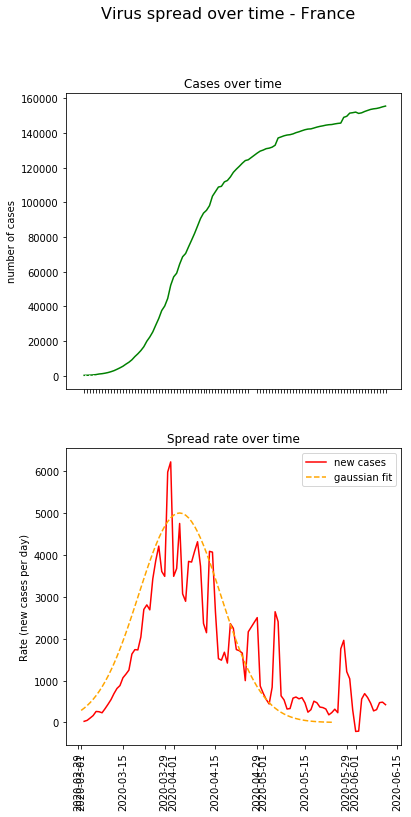

In [10]:
dummy = np.zeros(85)
plt.figure(figsize= (6,12))
plt.subplot(211)
plt.plot(df_national['date'],df_national['cases'], color = 'g') #trend cases
plt.plot(timerange,dummy, ':', color = 'w') 
plt.title('Cases over time')
plt.ylabel('number of cases')
plt.xticks(df_national['date']," ")
plt.subplot(212)
plt.plot(df_national['date'],df_national['ContagionRate'], color = 'r', label = 'new cases') #trend daily cases
plt.plot(timerange,y_e, '--', color = 'orange', label = 'gaussian fit') 
plt.title('Spread rate over time')
plt.ylabel('Rate (new cases per day)')
plt.legend()
plt.xticks(rotation=90)

plt.suptitle('Virus spread over time - France', fontsize=16)
plt.show()

# 2. Model for virus spread based on data from Italy and China 


### Get the rate for China

In [11]:
yc = df_china['Number of cases'].values # transform the column to differentiate into a numpy array

deriv_yc = np.diff(yc) # now we can get the derivative as a new numpy array
output_c = np.transpose(deriv_yc)

df_china['ContagionRate'] = pd.Series(output_c) # 

df_china = df_china[df_china['ContagionRate'] < 4500] # clean the chinese data from the suspicious "spike" of 12/2

In [12]:
y_it = df_italy['TotalPositiveCases'].values # transform the column to differentiate into a numpy array

deriv_y_it = np.gradient(y_it) # now we can get the derivative as a new numpy array
#np.savetxt("contagioitalia.csv", deriv_y, delimiter=",")
output_it = np.transpose(deriv_y_it)
#now add the numpy array to our dataframe
df_italy['ContagionRate'] = pd.Series(output_it)

In [13]:
df_italy.tail() # check the last dates for Italy 

,date,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,positivi_attuali,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,TotalPositiveCases,tamponi,casi_testati,note_it,note_en,Unnamed: 16,Unnamed: 17,ContagionRate
104,2020-06-07,NaN,4864,287,5151,30111,35262,-615,197,165837,33899,234998,4236535,2627188.0,NaN,NaN,NaN,NaN,238.5
105,2020-06-08,NaN,4729,283,5012,29718,34730,-532,280,166584,33964,235278,4263647,2643489.0,NaN,NaN,NaN,NaN,281.5
106,2020-06-09,NaN,4581,263,4844,28028,32872,-1858,283,168646,34043,235561,4318650,2675689.0,dc-IT-0041,dc-IT-0043,dc-EN-0041,dc-EN-0043,242.5
107,2020-06-10,NaN,4320,249,4569,27141,31710,-1162,202,169939,34114,235763,4381349,2713554.0,NaN,NaN,NaN,NaN,290.5
108,2020-06-11,NaN,4131,236,4367,26270,30637,-1073,379,171338,34167,236142,4443821,2746545.0,NaN,NaN,NaN,NaN,379.0


In [14]:
y_kr = df_korea_time['confirmed'].values # transform the column to differentiate into a numpy array

deriv_y_kr = np.gradient(y_kr) # now we can get the derivative as a new numpy array
#np.savetxt("contagioitalia.csv", deriv_y, delimiter=",")
output_kr = np.transpose(deriv_y_kr)
#now add the numpy array to our dataframe
df_korea_time['ContagionRate'] = pd.Series(output_kr)

In [15]:
X_ch = df_china.index.values

y_ch = df_china['ContagionRate'].values

#print(len(X_ch), len(y_ch))

### Gaussian model: international rates comparison

The most complete dataset at the time Covid-19 started to spread in Europe is that of China. We fit a model to this data, that closely resemble a bell curve

In [16]:
from scipy.optimize import curve_fit


def gauss_function(X, a, x0, sigma):
    return a*np.exp(-(X-x0)**2/(2*sigma**2))

#estimate mean and standard deviation
mean = 25 # select 25 as mean. For Italy 25 days correspond to 25/3/2020, for France to 31/3/2020
sigma = 30
#do the fit!
popt, pcov = curve_fit(gauss_function, X_ch, y_ch, p0 = [1, mean, sigma])


In [17]:
#Italian derivative data fit
x_it = df_italy.index.values
y_it = (df_italy['ContagionRate'].values)

init_vals2 = [6000, 30, 200]  # for [amp, cen, wid]
best_vals2, covar2 = curve_fit(gaussian, x_it, y_it, p0=init_vals2)
print('best_vals1: {}'.format(best_vals1))
#gaussian for Italy
# extrapolated gaussian
timeframe_days = 90
X1= np.arange(0, timeframe_days)
y1= gauss_function(X1, 6000,33,best_vals2[2])


best_vals1: [1.39934503e+05 3.32458777e+01 1.38146554e+01]


In [18]:
population_china = 1427647786 
population_italy = 60488373
population_france = 65241316

### Increase as days passed for all the countries

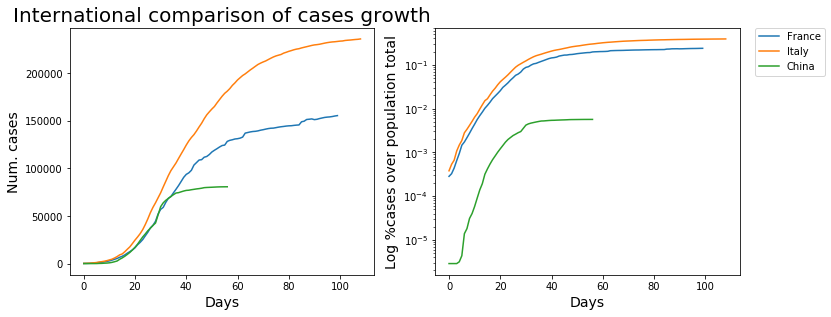

In [19]:
plt.figure(figsize=(12, 10))
plt.subplot(221)
plt.plot(df_national.index,df_national['cases'], label = 'France') #trend cases
plt.plot(df_italy.index,df_italy['TotalPositiveCases'], label = 'Italy') #trend cases
plt.plot(df_china.index, df_china['Number of cases'], label = 'China') #trend cases
plt.title('International comparison of cases growth', fontsize = 20)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Num. cases', fontsize=14)

plt.subplot(222)
plt.plot(df_national.index,(df_national['cases']/population_france)*100, label = 'France') #trend cases
plt.plot(df_italy.index,(df_italy['TotalPositiveCases']/population_italy)*100, label = 'Italy') #trend cases
plt.plot(df_china.index, (df_china['Number of cases']/population_china)*100, label = 'China') #trend cases
plt.xlabel('Days', fontsize=14)
plt.yscale('log')
plt.ylabel('Log %cases over population total', fontsize=14)


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

### Plot of the rate of increase fitted by the gaussian model above

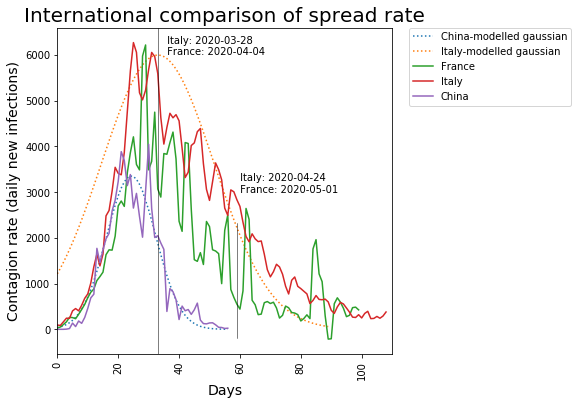

In [20]:
plt.figure(figsize= (6,6))
#plot the fit results
plt.plot(X_ch,gauss_function(X_ch, *popt), ':', label = 'China-modelled gaussian')
plt.plot(X1,y1, ':', label = 'Italy-modelled gaussian')
#plt.plot(X,gauss_function(X, *popt2), '--', label = 'France-modelled gaussian')
#confront with the given data
plt.plot(df_national.index,df_national['ContagionRate'], label = 'France') #trend cases
plt.plot(df_italy.index,df_italy['ContagionRate'], label = 'Italy') #trend cases
plt.plot(df_china.index, df_china['ContagionRate'], label = 'China') #trend cases
plt.axvline(x=33 , color='k', linewidth = 0.5)
plt.axvline(x=59, ymin=0.05, ymax=0.4, color='k', linewidth = 0.5)
plt.text(35, 6000, ' Italy: 2020-03-28\n France: 2020-04-04')
plt.text(59, 3000, ' Italy: 2020-04-24\n France: 2020-05-01')
plt.title('Cases over time')
plt.ylabel('Spread rate')

plt.xticks(rotation=90)
plt.xlim(0,110)
plt.ylabel('Contagion rate (daily new infections)', fontsize=14)
plt.xlabel('Days', fontsize = 14)
plt.legend

plt.title('International comparison of spread rate', fontsize = 20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

Importance of new cases relative to the total cases is well explained in this video

https://www.youtube.com/watch?v=54XLXg4fYsc

In [21]:
# clean up noise from low values
df_italy_clean = df_italy[df_italy['ContagionRate'] > 100] 
df_france_clean = df_national[df_national['ContagionRate'] > 100] 
df_china_clean = df_china[df_china['ContagionRate'] > 100] 
df_korea_clean = df_korea_time[df_korea_time['ContagionRate'] > 100]

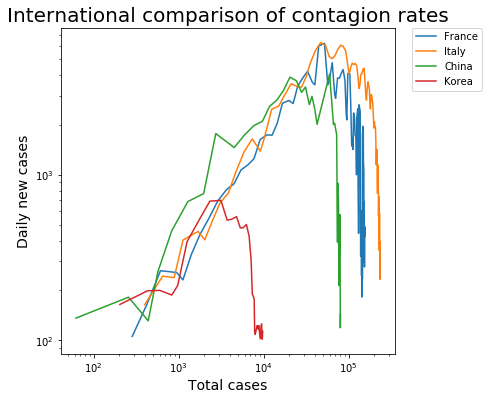

In [22]:
plt.figure(figsize=(6, 6))

plt.plot(df_france_clean['cases'], df_france_clean['ContagionRate'], label ='France')
plt.plot(df_italy_clean['TotalPositiveCases'], df_italy_clean['ContagionRate'], label = 'Italy')
plt.plot(df_china_clean['Number of cases'], df_china_clean['ContagionRate'], label = 'China')
plt.plot(df_korea_clean['confirmed'], df_korea_clean['ContagionRate'], label = 'Korea')

plt.xscale('log')
plt.yscale('log')
plt.ylabel('Daily new cases', fontsize=14)
plt.xlabel('Total cases', fontsize = 14)
plt.legend

plt.title('International comparison of contagion rates', fontsize = 20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


plt.show()

Big difference between Europe and Asia!!!!

# 3. Local statistics

### 3.1 Stats by district

In [23]:
df_departement =  raw_data[raw_data.granularite =='departement']
df_departement.rename(columns={'maille_nom':'district'},inplace=True) 
df_departement.tail()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,date,granularite,maille_code,district,cases,cas_ehpad,cas_confirmes_ehpad,cas_possibles_ehpad,deaths,deces_ehpad,reanimation,hospitalises,nouvelles_hospitalisations,nouvelles_reanimations,gueris,depistes,source_nom,source_url,source_archive,source_type
13530,2020-06-11,departement,DEP-971,Guadeloupe,NaN,NaN,NaN,NaN,16.0,NaN,0.0,12.0,0.0,0.0,74.0,NaN,Santé publique France Data,NaN,NaN,sante-publique-france-data
13531,2020-06-11,departement,DEP-972,Martinique,NaN,NaN,NaN,NaN,14.0,NaN,0.0,10.0,0.0,0.0,87.0,NaN,Santé publique France Data,NaN,NaN,sante-publique-france-data
13532,2020-06-11,departement,DEP-973,Guyane,NaN,NaN,NaN,NaN,2.0,NaN,7.0,42.0,9.0,1.0,133.0,NaN,Santé publique France Data,NaN,NaN,sante-publique-france-data
13533,2020-06-11,departement,DEP-974,La Réunion,NaN,NaN,NaN,NaN,1.0,NaN,1.0,19.0,0.0,0.0,124.0,NaN,Santé publique France Data,NaN,NaN,sante-publique-france-data
13534,2020-06-11,departement,DEP-976,Mayotte,NaN,NaN,NaN,NaN,23.0,NaN,13.0,43.0,6.0,1.0,290.0,NaN,Santé publique France Data,NaN,NaN,sante-publique-france-data


In [24]:
gb_departement =   df_departement[df_departement['date'] == df_departement['date'].max()].reset_index() # get sum of cases by district
gb_departement.rename(columns={'cases':'TotalPositiveCases'},inplace=True) 

gb_departement['mortality'] = (gb_departement['deaths']/gb_departement['hospitalises'])*100
gb_departement['recovered'] = (gb_departement['gueris']/gb_departement['hospitalises'])*100

gb_departement = gb_departement.sort_values(by=['hospitalises'], ascending=False).reset_index() # sort descending
gb_departement.head()

,level_0,index,date,granularite,maille_code,district,TotalPositiveCases,cas_ehpad,cas_confirmes_ehpad,cas_possibles_ehpad,...,nouvelles_hospitalisations,nouvelles_reanimations,gueris,depistes,source_nom,source_url,source_archive,source_type,mortality,recovered
0,92,13526,2020-06-11,departement,DEP-92,Hauts-de-Seine,NaN,NaN,NaN,NaN,...,7.0,2.0,4109.0,NaN,Santé publique France Data,NaN,NaN,sante-publique-france-data,121.281465,470.137300
1,93,13527,2020-06-11,departement,DEP-93,Seine-Saint-Denis,NaN,NaN,NaN,NaN,...,6.0,1.0,3404.0,NaN,Santé publique France Data,NaN,NaN,sante-publique-france-data,117.618469,413.608748
2,94,13528,2020-06-11,departement,DEP-94,Val-de-Marne,NaN,NaN,NaN,NaN,...,8.0,2.0,3786.0,NaN,Santé publique France Data,NaN,NaN,sante-publique-france-data,143.995098,463.970588
3,75,13509,2020-06-11,departement,DEP-75,Paris,NaN,NaN,NaN,NaN,...,9.0,2.0,5833.0,NaN,Santé publique France Data,NaN,NaN,sante-publique-france-data,229.278075,779.812834
4,91,13525,2020-06-11,departement,DEP-91,Essonne,NaN,NaN,NaN,NaN,...,4.0,2.0,2087.0,NaN,Santé publique France Data,NaN,NaN,sante-publique-france-data,87.671233,357.363014


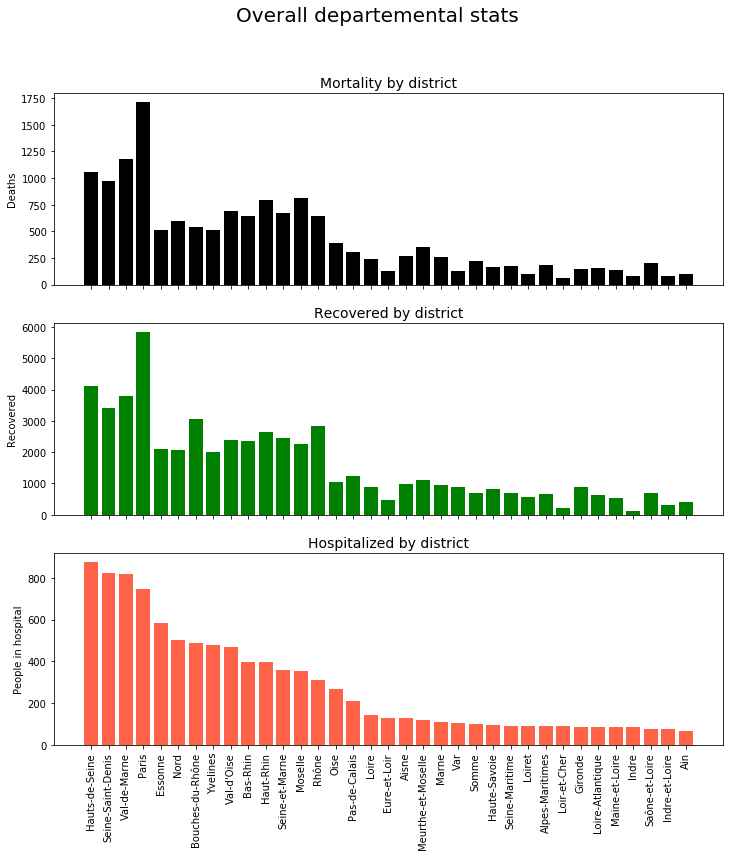

In [25]:
plt.figure(figsize=(12, 12))

plt.subplot(313)
plt.bar(gb_departement.district.iloc[0:35],gb_departement.hospitalises.iloc[0:35], color = 'tomato') #cases by region
plt.title('Hospitalized by district', fontsize = 14)
plt.ylabel('People in hospital')
plt.xticks(rotation=90)

plt.subplot(312)
plt.bar(gb_departement.district.iloc[0:35],gb_departement['gueris'].iloc[0:35], color = 'g') # % deaths by region
plt.title('Recovered by district', fontsize = 14)
plt.ylabel('Recovered')
plt.xticks(gb_departement['district'].iloc[0:35]," ")


plt.subplot(311)
plt.bar(gb_departement.district.iloc[0:35],gb_departement['deaths'].iloc[0:35], color = 'k') # % deaths by region

plt.ylabel('Deaths')
plt.xticks(gb_departement['district'].iloc[0:35]," ")
plt.title('Mortality by district', fontsize = 14)

plt.suptitle('Overall departemental stats', fontsize = 20)
plt.show()

 ### 3.2 Stats by region

In [26]:
df_region = raw_data[raw_data.granularite == 'region']
df_region = df_region.replace('Grand Est', 'Grand-Est')
df_region = df_region.replace('Île-de-France', 'Ile-de-France')
df_region = df_region.replace('Provence-Alpes-Côte d’Azur', "Provence-Alpes-Côte d'Azur")
df_region['maille_nom'].unique()


array(['Ile-de-France', 'Nouvelle-Aquitaine', 'Auvergne-Rhône-Alpes',
       'Bourgogne-Franche-Comté', 'Hauts-de-France', 'Grand-Est',
       'Guadeloupe', 'Martinique', 'Guyane', 'La Réunion', 'Mayotte',
       'Centre-Val de Loire', 'Normandie', 'Pays de la Loire', 'Bretagne',
       'Occitanie', "Provence-Alpes-Côte d'Azur", 'Corse'], dtype=object)

In [27]:
gb_region = df_region.groupby(['maille_nom']).max().reset_index() # get sum of cases by district
gb_region.rename(columns={'maille_nom':'region'},inplace=True) 
gb_region = gb_region.sort_values(by=['cases'], ascending=False) # sort descending

gb_region[:2]

,region,date,granularite,maille_code,cases,cas_ehpad,cas_confirmes_ehpad,cas_possibles_ehpad,deaths,deces_ehpad,reanimation,hospitalises,nouvelles_hospitalisations,nouvelles_reanimations,gueris,depistes,source_nom,source_type
9,Ile-de-France,2020-06-11,region,REG-11,7660.0,NaN,NaN,NaN,7295.0,NaN,2668.0,13209.0,1796.0,304.0,26083.0,NaN,Santé publique France,sante-publique-france
5,Grand-Est,2020-06-11,region,REG-44,5479.0,NaN,NaN,NaN,3500.0,NaN,971.0,4993.0,697.0,122.0,11543.0,NaN,Santé publique France,sante-publique-france


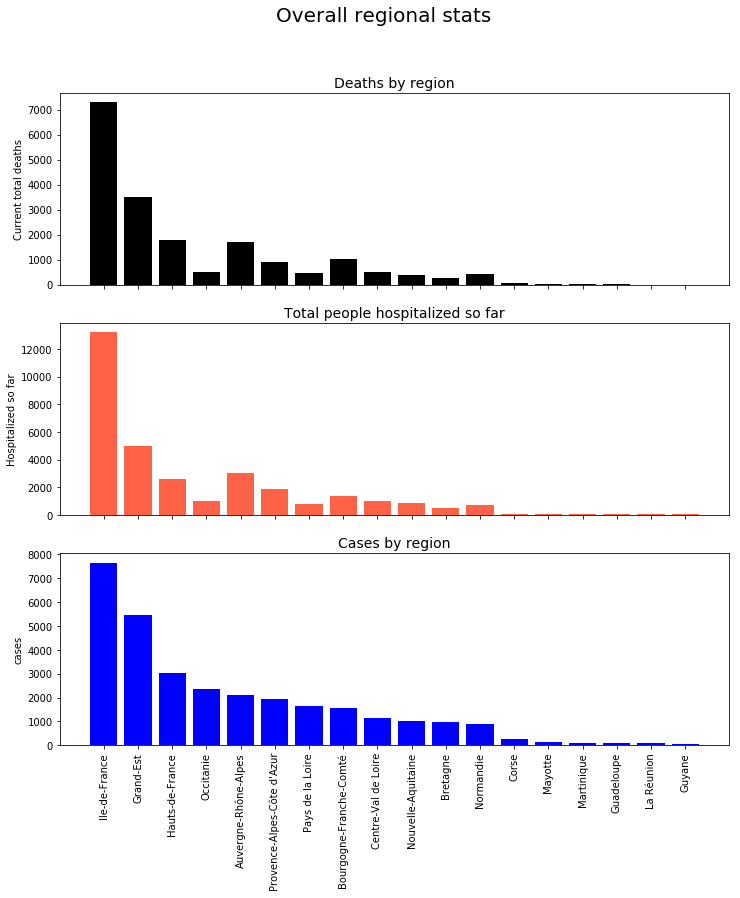

In [28]:
plt.figure(figsize=(12, 12))

plt.subplot(311)
plt.bar(gb_region.region,gb_region['deaths'], color = 'k') # deaths by region
plt.ylabel('Current total deaths')
plt.xticks(rotation=90)
plt.xticks(gb_region['region']," ")
plt.title('Deaths by region', fontsize = 14)

plt.subplot(312)
plt.bar(gb_region.region,gb_region.hospitalises, color = 'tomato') #in hospital by region
plt.title('Total people hospitalized so far', fontsize = 14)
plt.ylabel('Hospitalized so far')
plt.xticks(gb_region['region']," ")

plt.subplot(313)
plt.bar(gb_region.region,gb_region['cases'], color = 'b') # cases by region
plt.ylabel('cases')
plt.xticks(rotation=90)
plt.title('Cases by region', fontsize = 14)

plt.suptitle('Overall regional stats', fontsize = 20)
plt.show()

### 3.3 Paris vs. Marseille

In [29]:
reg_features = ['date','cases','deaths','reanimation','hospitalises','gueris'] # list relevant features

In [30]:
population13 = 1966005 
population75 = 2187526

In [31]:
# data for Marseille and Paris
df_13 = raw_data[raw_data.maille_code == 'DEP-13'] 
df_13 = df_13[reg_features] # select relevant features
df_75 = raw_data[raw_data.maille_code == 'DEP-75'] 
df_75 = df_75[reg_features] # select relevant features
df_13.tail()

,date,cases,deaths,reanimation,hospitalises,gueris
12962,2020-06-07,NaN,533.0,55.0,517.0,3033.0
13083,2020-06-08,NaN,537.0,55.0,509.0,3044.0
13204,2020-06-09,NaN,539.0,52.0,507.0,3048.0
13325,2020-06-10,NaN,540.0,50.0,496.0,3063.0
13446,2020-06-11,NaN,541.0,50.0,490.0,3070.0


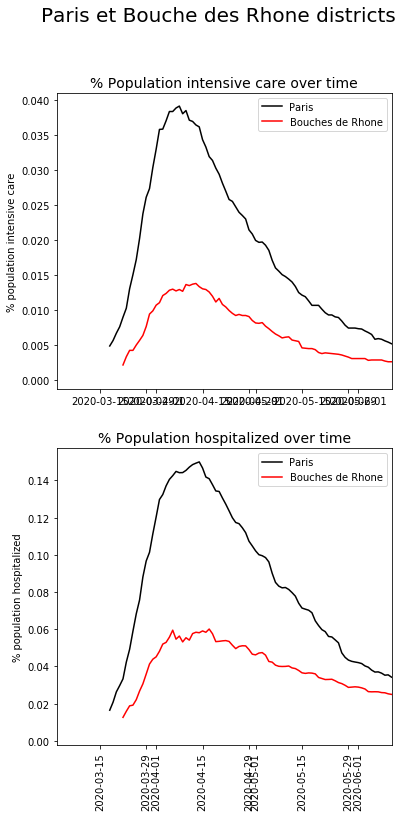

In [32]:
plt.figure(figsize=(6,12))
plt.subplot(211)
plt.plot(df_75.date,(df_75['reanimation']/population75)*100, color = 'k', label =  'Paris')
plt.plot(df_13.date,(df_13['reanimation']/population13)*100, color = 'r', label =  'Bouches de Rhone') 
plt.ylabel('% population intensive care')
plt.xlim('2020-03-02', max(df_13.date))
plt.legend()
plt.title('% Population intensive care over time', fontsize = 14)

plt.subplot(212)
plt.plot(df_75.date,(df_75['hospitalises']/population75)*100, color = 'k', label =  'Paris')
plt.plot(df_13.date,(df_13['hospitalises']/population13)*100, color = 'r', label =  'Bouches de Rhone')
plt.ylabel('% population hospitalized')
plt.xlim('2020-03-02', max(df_13.date)) 
plt.xticks(rotation=90)
plt.legend()
plt.title('% Population hospitalized over time', fontsize = 14)

plt.suptitle('Paris et Bouche des Rhone districts', fontsize = 20)
plt.show()

In [33]:
# data for Ile de France (region around Paris)

df_IDF = raw_data[raw_data.maille_code == 'REG-11']
#df_IDF = df_IDF.dropna(subset=['cases']) # drop empty cells
df_IDF = df_IDF[reg_features] # select relevant features

In [34]:
# data for Provence (region around Marseille)
df_PACA = raw_data[raw_data.maille_code == 'REG-93'] 
#df_PACA = df_PACA.dropna(subset=['cases'])# drop empty cells
df_PACA = df_PACA[reg_features] # select relevant features

In [35]:
IDFpopulation = 12174880
PACApopulation = 5030890

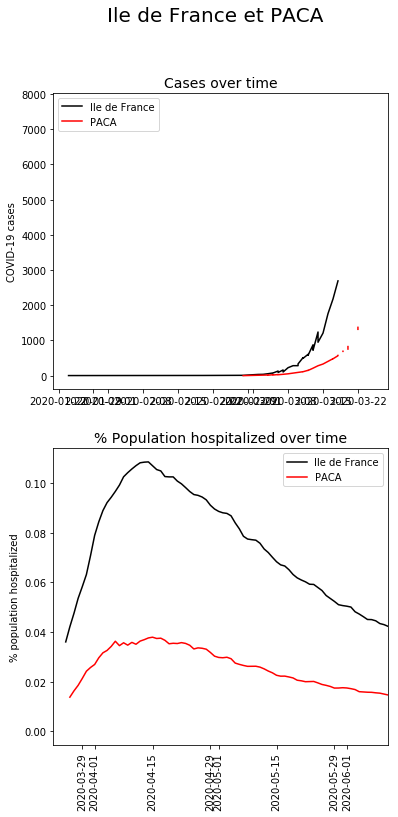

In [36]:
plt.figure(figsize=(6, 12))

plt.subplot(211)
plt.plot(df_IDF.date,df_IDF['cases'], color = 'k', label =  'Ile de France') 
plt.plot(df_PACA.date,df_PACA['cases'], color = 'r', label =  'PACA') 
#plt.xlim('2020-03-15', max(df_PACA.date))   # set the xlim to left, right
plt.ylabel('COVID-19 cases')

plt.legend()
plt.title('Cases over time', fontsize = 14)

plt.subplot(212)
plt.plot(df_IDF.date,(df_IDF['hospitalises']/IDFpopulation)*100, color = 'k', label =  'Ile de France') # % in hospital of total Ile de France population
plt.plot(df_PACA.date,(df_PACA['hospitalises']/PACApopulation)*100, color = 'r', label =  'PACA') # % in hospital of total PACA population
plt.ylabel('% population hospitalized')
plt.xlim('2020-03-22', max(df_PACA.date)) 
plt.xticks(rotation=90)
plt.legend()
plt.title('% Population hospitalized over time', fontsize = 14)

plt.suptitle('Ile de France et PACA', fontsize = 20)
plt.show()

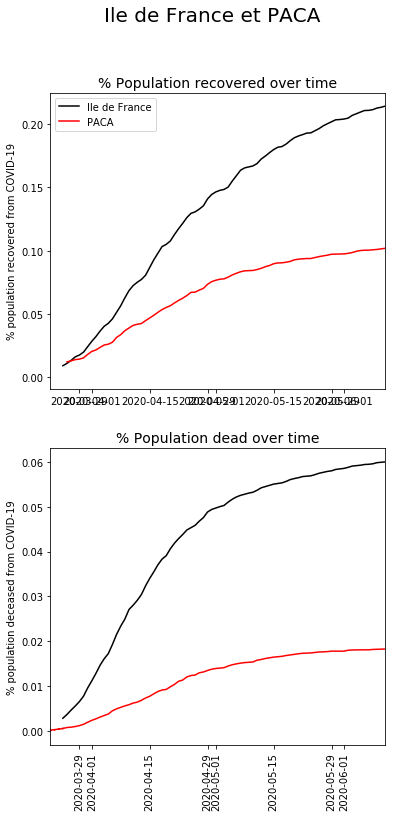

In [37]:
plt.figure(figsize=(6, 12))

plt.subplot(211)
plt.plot(df_IDF.date,(df_IDF['gueris']/IDFpopulation)*100, color = 'k', label =  'Ile de France') # % recovered of total Ile de France population
plt.plot(df_PACA.date,(df_PACA['gueris']/PACApopulation)*100, color = 'r', label =  'PACA') # % recovered of total PACA population
plt.ylabel('% population recovered from COVID-19')
plt.xlim('2020-03-22', max(df_PACA.date)) 
plt.legend()
plt.title('% Population recovered over time', fontsize = 14)

plt.subplot(212)
plt.plot(df_IDF.date,(df_IDF['deaths']/IDFpopulation)*100, color = 'k', label =  'Ile de France') # % deaths of total Ile de France population
plt.plot(df_PACA.date,(df_PACA['deaths']/PACApopulation)*100, color = 'r', label =  'PACA') # % deaths of total PACA population
plt.ylabel('% population deceased from COVID-19')
plt.xlim('2020-03-22', max(df_PACA.date)) 
plt.xticks(rotation=90)
plt.title('% Population dead over time', fontsize = 14)

plt.suptitle('Ile de France et PACA', fontsize = 20)
plt.show()

## How fast did COVID-19 spread in South Korea compared to similar diseases?


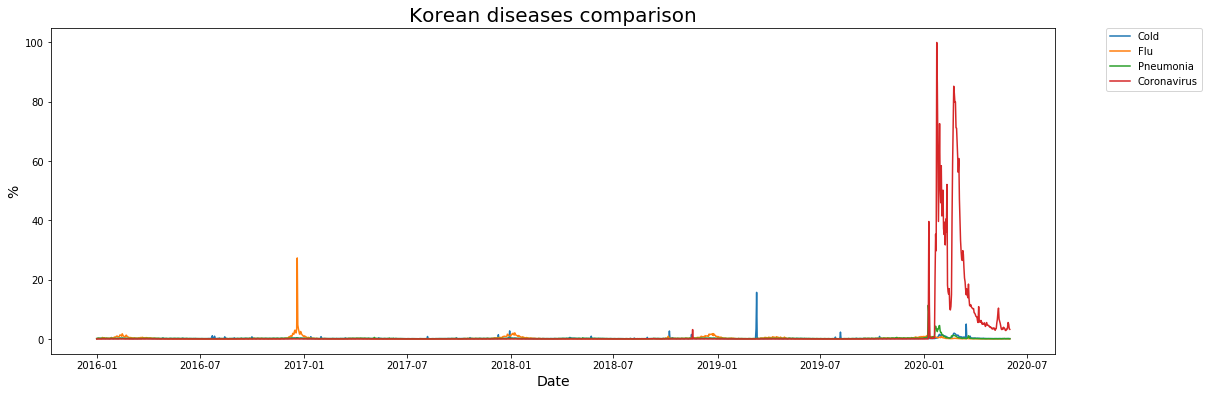

In [38]:
plt.figure(figsize=(18,6))
plt.plot(df_korea_trend['date'], df_korea_trend['cold'], label = 'Cold')
plt.plot(df_korea_trend['date'], df_korea_trend['flu'], label ='Flu')
plt.plot(df_korea_trend['date'], df_korea_trend['pneumonia'], label = 'Pneumonia')
plt.plot(df_korea_trend['date'], df_korea_trend['coronavirus'], label = 'Coronavirus')




plt.ylabel('%', fontsize=14)
plt.xlabel('Date', fontsize = 14)
plt.legend

plt.title('Korean diseases comparison', fontsize = 20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

 # How is COVID-19 likely to be spread? (South Korea Stats)

In [39]:
df_korea.head()

,case_id,province,city,group,infection_case,confirmed,latitude,longitude
0,1000001,Seoul,Yongsan-gu,True,Itaewon Clubs,133.0,37.538621,126.992652
1,1000002,Seoul,Guro-gu,True,Guro-gu Call Center,99.0,37.508163,126.884387
2,1000003,Seoul,Dongdaemun-gu,True,Dongan Church,20.0,37.592888,127.056766
3,1000004,Seoul,Guro-gu,True,Manmin Central Church,41.0,37.481059,126.894343
4,1000005,Seoul,Eunpyeong-gu,True,Eunpyeong St. Mary's Hospital,14.0,37.63369,126.9165


In [40]:
df_korea_patient.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


In [41]:
df_korea_patient.infection_case.value_counts()

contact with patient                     1182
overseas inflow                           703
etc                                       601
Itaewon Clubs                             156
Guro-gu Call Center                       112
Shincheonji Church                        107
Coupang Logistics Center                   70
Onchun Church                              33
Bonghwa Pureun Nursing Home                31
gym facility in Cheonan                    30
Ministry of Oceans and Fisheries           28
Cheongdo Daenam Hospital                   21
Dongan Church                              17
Eunpyeong St. Mary's Hospital              16
Gyeongsan Seorin Nursing Home              15
Seongdong-gu APT                           13
Gyeongsan Jeil Silver Town                 12
Milal Shelter                              11
Gyeongsan Cham Joeun Community Center      10
KB Life Insurance                           8
Samsung Medical Center                      7
Geochang Church                   

Based on these data the most likely places to catch Coronavirus are religious gatherings, hospitals and workplaces

In [42]:
# at what age can people get infected?
df_korea_age = df_korea_patient.groupby(['age']).count().reset_index()
df_korea_age = df_korea_age[['age','patient_id']]


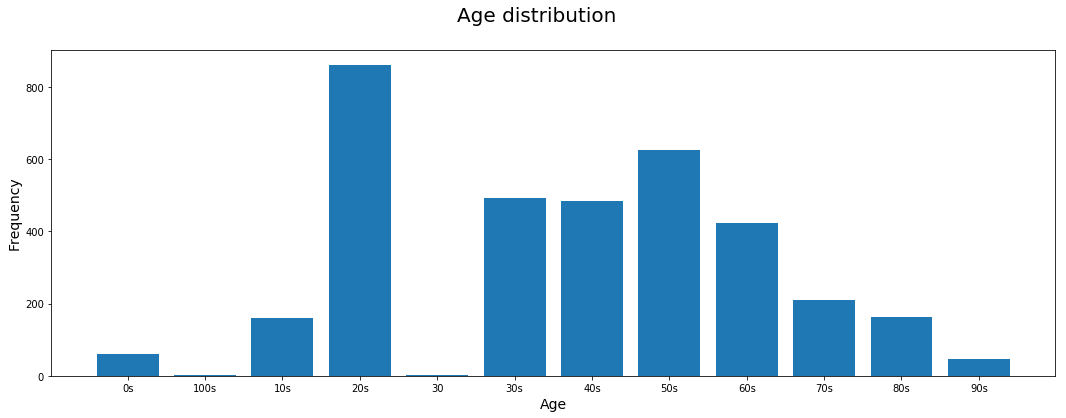

In [43]:
plt.figure(figsize=(18,6))
plt.bar(df_korea_age['age'], df_korea_age['patient_id']) 
plt.xlabel('Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.suptitle('Age distribution', fontsize = 20)
plt.show()